# LAUNCH ME

Following this file, you will be able to see our experiments and reproduce the result we shown in our project.

## 0. Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from PIL import Image

import kagglehub


# Our implemented parallelized class from the paper Dictionary Learning for Sparse Coding
from src import DictionaryAlgoParallel 

# This function will import the dataset we need
from src import get_boat_data, get_instruments_data, get_berekley_data_loaders 



## I. Boat dataset

## I.1 Hyperparameters

In [9]:
patch_size = (16,16)
lbd = 1e-3
nb_atoms = 30
dic_update_steps=2
use_cuda=False # If you turn it to True, you need rapids. You should know that it is much slower than cpu implementation as joblib parallelization of for python loop does not work well with cuda uses.
dico_update="quick_update"
n_jobs=-1
number_atoms_computed_omp = 20 

Lets first import the dataset from kaggle and parse it.

In [10]:
from src import plot_image_grid
from src import get_pacthed_image, get_unpatched_image

def rescale_patch(patch, new_size=patch_size):
    patch_uint8 = (patch * 255).clip(0, 255).astype(np.uint8) if patch.dtype != np.uint8 else patch
    pil_img = Image.fromarray(patch_uint8)
    downscaled_image = pil_img.resize(new_size, Image.Resampling.LANCZOS)
    downscaled_np = np.array(downscaled_image)
    return downscaled_np


path_boat = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path_boat)
x,y_true, images, jsondata = get_boat_data(path_boat)

x = np.array(list(map(rescale_patch, x)))

Path to dataset files: /home/antoine/.cache/kagglehub/datasets/rhammell/ships-in-satellite-imagery/versions/9


Now that we have our dataset, we can check what it contains.

In [11]:
def preprocessing(datas):
    """
    Flatten our data.
    :param datas: (n_samples, n_rows, n_cols, n_channels)
    :return: 
    """
    n_samples, n_rows, n_cols, n_channels = datas.shape
    datas = datas.reshape(n_samples, -1) / 255
    preprocessed = datas
    infos = {"shape" : (n_rows, n_cols)}
    return  preprocessed, infos

def postprocessing(datas, infos, ):
    """
    Unflatten our data to reconstruct our patch.
    """
    n_rows, n_cols = infos["shape"]
    results = datas
    results = results.reshape(len(datas), n_rows, n_cols, 3, order="C").clip(0,1)
    return results

x_boat = x[y_true == 1.]
x_background = x[y_true == 0.]
x_background_preprocessing, infos_background_preprocessing = preprocessing(x_background)
x_boat_preprocessing, infos_boat_preprocessing = preprocessing(x_boat)

print(" training data shape", x_background_preprocessing.shape)
print(" boat (not used in training) data shape", x_boat_preprocessing.shape)



 training data shape (3000, 768)
 boat (not used in training) data shape (1000, 768)


Let's check what are the boat patches we extracted.

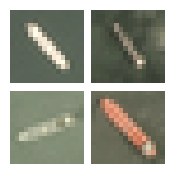

In [12]:
plot_image_grid(x_boat, 2, figsize = (2,2))

We can also review the types of background images we have in our dataset

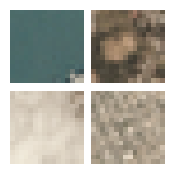

In [13]:
plot_image_grid(x_background, 2, figsize = (2,2))

We can now train our Dictionary using our background preprocessed data. As we have only 3000 patches to train on, the training should be very quick.

In [14]:
def get_trained_dico():
    m = patch_size[0] * patch_size[1]*3
    dict_learner = DictionaryAlgoParallel(m=m, k=nb_atoms, lbd=lbd, dic_update_steps=dic_update_steps, use_cuda=False, dico_update=dico_update, n_jobs=n_jobs, verbose=True) # Initialize our python class containing our training logic
    
    from tqdm import tqdm
    from itertools import cycle
    class FiniteGenerator:
        def __init__(self, iterable, nb_elt,  batch_size = 8):
            self.iterable = iterable
            self.nb_elt = nb_elt
            self.batch_size = batch_size
        def __len__(self):
            return self.nb_elt
        def __iter__(self,):
            infinite_loader = cycle(self.iterable)          
            for k in tqdm(range(self.nb_elt // self.batch_size)):
                data = np.array([next(infinite_loader) for _ in range(self.batch_size)])
                yield torch.from_numpy(data).float()
    
    # Create our training iterable
    x_training = FiniteGenerator(x_background_preprocessing, 4*len(x_boat_preprocessing), batch_size=32) 
    
    # Initialize out dataset to element of our training set.
    dict_learner.D = torch.tensor(torch.from_numpy(x_background_preprocessing[:nb_atoms].T), dtype=torch.float)
    dict_learner.D.to(dict_learner.device)
    
    # fit our dictionary on our data using our parallelized algorithm.
    dict_learner.fit(x_training)
    return dict_learner

dict_learner = get_trained_dico()

100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


Let's see how our elements are encoded.

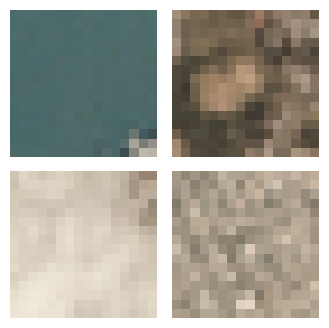

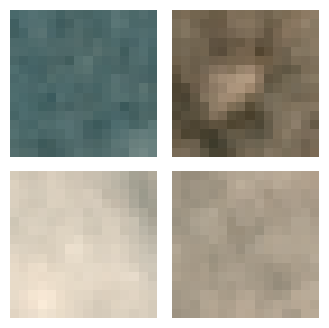

In [15]:
def make_prediction(X,infos_preprocessing, dict_learner):
    weights_encoded = dict_learner.transform(X, n_nonzero_coefs=number_atoms_computed_omp) # We use OMP for inference.
    #print(weights_encoded.shape, dict_learner.components_.shape)
    x_transformed = weights_encoded @ dict_learner.components_
    x_transformed = postprocessing(x_transformed, infos_preprocessing)
    return x_transformed

x_transformed = make_prediction(x_background_preprocessing, infos_background_preprocessing, dict_learner)
plot_image_grid(x_background, 2)
plot_image_grid(x_transformed, 2)

We see that background images are not perfectly encoded. To have more accurate results, we can increase the number of atoms to learn in our dictionary or increase the number of atoms used in the OMP reconstruction.

We can also see how boats are encoded.

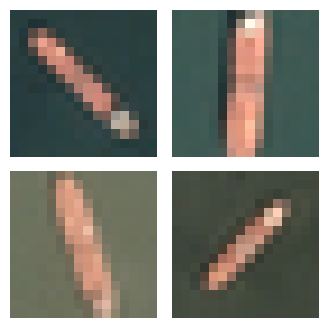

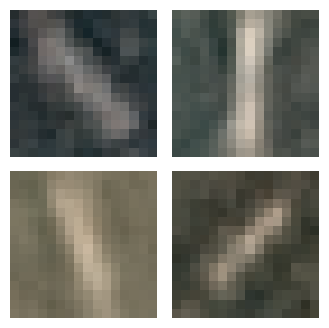

In [16]:
x_transformed_boat = make_prediction(x_boat_preprocessing, infos_boat_preprocessing, dict_learner)
plot_image_grid(x_boat[5:], 2)
plot_image_grid(x_transformed_boat[5:], 2)

It seems that boats encoding is much more degraded than typical background images.

Let's check the reconstruction effect on a full satellite image. Our goal is to reveal boats as those should be wrongly encoded by our dictionary.

image original size (1828, 2844, 3)
w pixel cropped : 68 
 l pixel cropped : 44


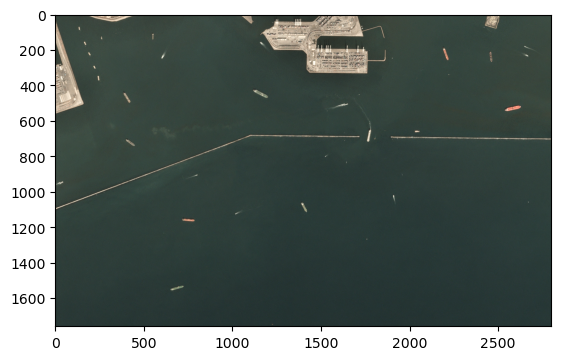

In [31]:
image_np = np.array(images[7])
print("image original size", image_np.shape)

patches, cropped_shape = get_pacthed_image(image_np, 80)
sattelite_img_cropped = get_unpatched_image(patches, cropped_shape)


plt.imshow(sattelite_img_cropped)

We can now represent the encoded image

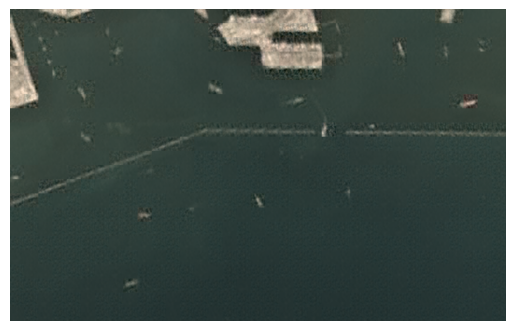

In [32]:
patches_downscaled = np.array(list(map(lambda x : rescale_patch(x, new_size=patch_size), patches))) 
patches_preprocessed, infos_inference_preprocessed = preprocessing(patches_downscaled)
x_transformed_inference = make_prediction(patches_preprocessed, infos_inference_preprocessed, dict_learner)
x_postprocess_inference = postprocessing(x_transformed_inference, infos_inference_preprocessed)
    
generated_patches_upscaled = np.array(list(map(lambda x : rescale_patch(x, new_size=(80,80)), x_postprocess_inference)))
generated_img = get_unpatched_image(generated_patches_upscaled, cropped_shape)

fig, ax = plt.subplots()  
ax.axis('off')           
ax.imshow(generated_img)  
plt.show()    


We see that the coast is not that well reconstructed as naturally it contains much more details then basic water or ground background. We can also see that boats where wrongly encoded (which is the behaviour we want).

We can plot the pixelwise l2 difference to confirm that boats were wrongly encoded.

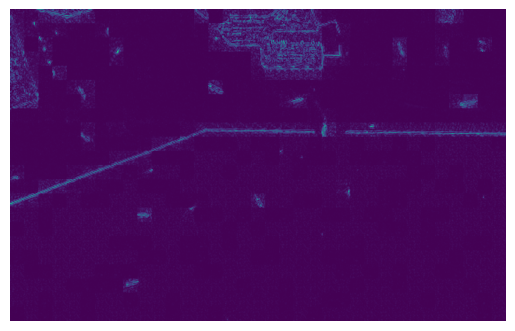

In [33]:
l_2_patch_differences=  np.abs(x_postprocess_inference - patches_downscaled / 255)
l_2_patch_differences_upscaled = np.array(list(map(lambda x : rescale_patch(x, new_size=(80,80)), l_2_patch_differences)))
reconstructed = get_unpatched_image(l_2_patch_differences_upscaled, cropped_shape)
reconstructed = reconstructed.mean(axis=-1)
fig, ax = plt.subplots()  
ax.axis('off')
ax.imshow(sattelite_img_cropped)
ax.imshow(reconstructed)  
plt.show()         

We see that we can segment out boats from this analysis.

We can plot the dictionary atoms to see how images are encoded :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1102161].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0782067].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3190851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.082625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0445288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1497134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0943532].
Clipping input data to the valid ra

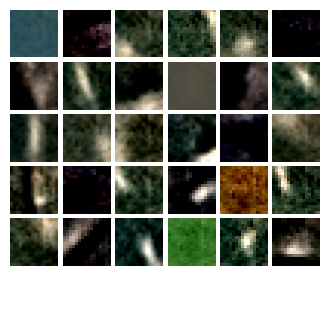

In [34]:
dico = dict_learner.components_
x_transformed = postprocessing(dico, infos_boat_preprocessing)
plot_image_grid(8*x_transformed, 6) # You can increase the multiplication coefficient if the atoms are plotted as black.

The result vary a lot if we modify the hyperparameters lambda (lbd). For low lambda, the dictionary seems very chaotic whereas when increasing lambda to $10^{-4}$, $10^{-3}$, $10^{-2}$, the atoms tends to ressemble initializing element of our dictionary. 

## II. Instrument dataset

In [ ]:
path_instrument = kagglehub.dataset_download("soumendraprasad/musical-instruments-sound-dataset")

print("Path to dataset files:", path_instrument)

Ys, sampling_rates, files = get_instruments_data(path_instrument)

def to_mono(s):
    if len(s.shape) == 2:  # Stereo signal
        return np.mean(s, axis=1)  # Average the two channels to get mono
    return s

signals = list(map(to_mono, Ys))

## III Berkeley image dataset

### III.1 Hyperparameters


In [ ]:
patch_size = (12,12)
batch_size = ...

### III.2 Import dataset


In [ ]:
from src.dataset.torch_dataset import PatchAndFlatenDataset, NormalizationType


path_berkeley = kagglehub.dataset_download("balraj98/berkeley-segmentation-dataset-500-bsds500")

print("Path to dataset files:", path_berkeley)

get_berekley_data_loaders(osp.join(path_berkeley, "images"),  patch_size=patch_size, patches_per_image=5, batch_size=batch_size, norm_type=NormalizationType.ZSCORE)